In [ ]:
# !pip3 install torch

In [ ]:
# !pip3 install numpy

In [ ]:
import numpy as np
import torch
import torch.nn as nn

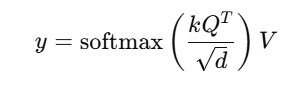

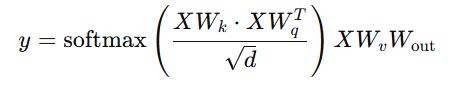

### This function implements the self-attention mechanism:

It transforms the input into three components: keys, queries, and values.
It computes the attention scores between each token (based on the similarity of its key to all other queries), scales the scores for numerical stability, and applies a mask to block certain positions from attending to others.
The softmax function converts the attention scores into probabilities.
The output is a weighted sum of the value vectors, followed by a linear transformation using W_out.

In [ ]:
def softmax(z):
  z = np.exp(z - z.max(axis= -1, keepdims= True))
  return z / z.sum(axis = -1, keepdims = True)

def self_attention(x, mask, W_kqv, W_out):
  k,q,v = np.split(x@W_kqv, 3, axis=1)
  attn = softmax(k@q.T / np.sqrt(x.shape[1]) + mask)
  return attn@v@W_out, attn

In [ ]:
T, d = 100, 64
attn = nn.MultiheadAttention(d, 1, bias=False, batch_first=True)
M = torch.triu(-float("inf")*torch.ones(T,T),1)
X = torch.randn(1,T,d)
Y_, A_ = attn(X,X,X, attn_mask=M)

In [ ]:
attn.in_proj_weight.shape

torch.Size([192, 64])

In [ ]:
Y,A = self_attention(X[0].numpy(), M.numpy(),
                     attn.in_proj_weight.detach().numpy().T,
                     attn.out_proj.weight.detach().numpy().T)

In [ ]:
np.linalg.norm(Y - Y_[0].detach().numpy())

1.692292e-06

## Minibatching

In [ ]:
c = np.random.randn(5,4,10,3)
d = np.random.randn(3,6)
(c@d).shape

(5, 4, 10, 6)

In [ ]:
c.reshape(-1,3).shape

(200, 3)

In [ ]:
def self_attention(x, mask, W_kqv, W_out):
  k,q,v = np.split(x@W_kqv, 3, axis=-1)
  attn = softmax(k@q.swapaxes(-1,-2) / np.sqrt(x.shape[-1]) + mask)
  return attn@v@W_out, attn

In [ ]:
B,T,d = 50,100,64
X = torch.randn(B,T,d)
M = torch.triu(-float("inf")*torch.ones(T,T), 1)
Y_, A_ = attn(X,X,X, attn_mask=M)

In [ ]:
Y, A = self_attention(X.numpy(), M.numpy(),
                      attn.in_proj_weight.detach().numpy().T,
                      attn.out_proj.weight.detach().numpy().T)

In [ ]:
np.linalg.norm(A - A_.detach().numpy())

1.6088802e-06

## Multihead attention

In [ ]:
def multihead_attention(X, mask, heads, W_kqv, W_out):
  B,T,d= X.shape
  K,Q,V = np.split(X@W_kqv, 3, axis= -1)
  K,Q,V = [a.reshape(B, T, heads, d // heads).swapaxes(1,2) for a in (K,Q,V)]
  attn = softmax(K@Q.swapaxes(-1,-2) / np.sqrt(d // heads) + mask)
  return (attn@V).swapaxes(1,2).reshape(B,T,d) @ W_out, attn


In [ ]:
heads = 4
attn = nn.MultiheadAttention(d, heads, bias = False, batch_first=True)
Y_, A_ = attn(X,X,X, attn_mask = M)

In [ ]:
Y, A = multihead_attention(X.numpy(), M.numpy(), heads,
                           attn.in_proj_weight.detach().numpy().T,
                           attn.out_proj.weight.detach().numpy().T)

In [ ]:
np.linalg.norm(A.mean(axis=1) - A_.detach().numpy())

1.0400792e-06

## Transformer Block

In [ ]:
def layer_norm(z, eps):
  return (z - z.mean(axis=-1, keepdims=True)) / np.sqrt(z.var(axis=-1, keepdims=True) + eps)

def relu(z):
  return np.maximum(z,0)

def transformer(x,mask, heads, W_kqv, W_out, W_ff1, W_ff2, eps):
  z = layer_norm(x + multihead_attention(x, mask, heads, W_kqv, W_out)[0], eps)
  return layer_norm(z + relu(z@W_ff1)@W_ff2, eps)

In [ ]:
trans = nn.TransformerEncoderLayer(d, heads, dim_feedforward=128, dropout=0.0, batch_first=True)
trans.linear1.bias.data.zero_()
trans.linear2.bias.data.zero_()
Y_ = trans(X,M)

In [ ]:
Y = transformer(X.numpy(), M.numpy(), heads,
                trans.self_attn.in_proj_weight.detach().numpy().T,
                trans.self_attn.out_proj.weight.detach().numpy().T,
                trans.linear1.weight.detach().numpy().T,
                trans.linear2.weight.detach().numpy().T,
                trans.norm1.eps)

In [ ]:
np.linalg.norm(Y - Y_.detach().numpy())

5.9700644e-05